In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [2]:
def get_kraken_data(symbol):
    filename = 'Kraken_OHLCVT/{}USD_1.csv'.format(symbol.replace('BTC', 'XBT'))
    if not os.path.exists(filename):
        return pd.DataFrame()
    df = pd.read_csv(
        filename,
        names=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume', 'trades']
    )
    
    df['timestamp_5m'] = (df['timestamp'] // 300) * 300
    df['timestamp_1h'] = (df['timestamp'] // 3600) * 3600

    df_5m = pd.concat([
        df.groupby('timestamp_5m')['cl'].nth(-1),
    ], axis=1)
    df_5m = df_5m.reset_index()
    df_5m['timestamp_1h'] = (df_5m['timestamp_5m'] // 3600) * 3600
    
    df = pd.concat([
        df.groupby('timestamp_1h')['op'].nth(0),
        df.groupby('timestamp_1h')['hi'].max(),
        df.groupby('timestamp_1h')['lo'].min(),
        df.groupby('timestamp_1h')['cl'].nth(-1),
        df.groupby('timestamp_1h')['volume'].sum(),
        df.groupby('timestamp_1h')['trades'].sum(),
        df_5m.groupby('timestamp_1h')['cl'].mean().rename('twap_5m'),
    ], axis=1)
    
    df.index.rename('timestamp', inplace=True)
    
    df['symbol'] = symbol
    df = df.reset_index()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df = df.set_index(['timestamp', 'symbol'])
    return df

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    dfs = list(map(get_kraken_data, symbols))
    df = df.copy()
    df['extended'] = False
    df = pd.concat([df] + dfs)
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    # df = df.loc[df.index.drop_duplicates()]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()
    
display(get_kraken_data('BTC'))

,,op,hi,lo,cl,volume,trades,twap_5m
timestamp,symbol,,,,,,,
2013-10-06 21:00:00+00:00,BTC,122.00000,122.00000,122.00,122.00,0.100000,1,122.000000
2013-10-07 20:00:00+00:00,BTC,123.61000,123.61000,123.61,123.61,0.100000,1,123.610000
2013-10-08 02:00:00+00:00,BTC,123.91000,123.91000,123.90,123.90,1.991600,2,123.900000
2013-10-08 05:00:00+00:00,BTC,124.19000,124.19000,124.18,124.18,2.000000,2,124.180000
2013-10-09 09:00:00+00:00,BTC,124.01687,124.01687,123.84,123.84,2.823000,3,123.840000
...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00+00:00,BTC,18949.70000,19000.00000,18841.00,18883.90,212.169331,1651,18924.191667
2022-06-30 20:00:00+00:00,BTC,18896.80000,19041.50000,18617.50,18732.30,343.422628,1832,18880.508333
2022-06-30 21:00:00+00:00,BTC,18731.60000,18931.20000,18694.80,18796.60,300.613095,1209,18848.266667


In [3]:
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC']

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)
df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2020-10-29 06:00:00+00:00,ADAUSDT,0.10008,0.10017,0.09963,0.09981,10969098.0,1.095526e+06,4515.0,5102617.0,...,0.099827,0.099816,0.000142,0.000062,0.099872,0.099787,0.000039,-0.000047,0.000853,9.458891e-07
1,2020-11-16 11:00:00+00:00,ADAUSDT,0.10301,0.10315,0.10238,0.10241,9364947.0,9.630226e+05,4866.0,4743491.0,...,0.102854,0.102832,0.000137,0.000075,0.102920,0.102804,0.000057,-0.000058,0.001125,1.536971e-06
2,2020-11-15 11:00:00+00:00,ADAUSDT,0.10314,0.10371,0.10263,0.10266,13117924.0,1.353000e+06,5305.0,6854920.0,...,0.103153,0.103172,0.000251,0.000090,0.103217,0.103105,0.000057,-0.000055,0.001081,1.504847e-06
3,2020-11-16 02:00:00+00:00,ADAUSDT,0.10013,0.10062,0.09967,0.10016,11115604.0,1.112733e+06,4428.0,5430827.0,...,0.100150,0.100116,0.000235,0.000102,0.100219,0.100095,0.000071,-0.000054,0.001240,1.886836e-06
4,2020-11-15 06:00:00+00:00,ADAUSDT,0.10437,0.10510,0.10430,0.10480,8020046.0,8.400803e+05,4385.0,5095373.0,...,0.104652,0.104661,0.000203,0.000077,0.104698,0.104610,0.000049,-0.000039,0.000844,1.025699e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234480,2022-03-02 17:00:00+00:00,MATICUSDT,1.65530,1.66740,1.63330,1.63530,8673007.0,1.433102e+07,29345.0,3995194.0,...,1.654248,1.653250,0.008710,0.002279,1.656182,1.652683,0.001563,-0.001935,0.002117,5.563870e-06
234481,2022-03-15 19:00:00+00:00,MATICUSDT,1.39280,1.40920,1.39040,1.39720,10476814.0,1.467104e+07,29848.0,5789143.0,...,1.399227,1.399058,0.003782,0.001833,1.400578,1.397905,0.001422,-0.001252,0.001910,4.260190e-06
234482,2022-03-08 14:00:00+00:00,MATICUSDT,1.45670,1.46720,1.44040,1.44720,15283799.0,2.221595e+07,42231.0,7554742.0,...,1.452727,1.452175,0.005306,0.003493,1.455335,1.450733,0.002475,-0.002127,0.003167,1.264309e-05
234483,2022-02-20 23:00:00+00:00,MATICUSDT,1.54070,1.54990,1.50650,1.51090,14043737.0,2.151575e+07,39717.0,6385606.0,...,1.528815,1.528275,0.010250,0.002810,1.530765,1.527123,0.001437,-0.002205,0.002381,7.132379e-06


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-19 18:00:00+00:00 ETH     1207.41000  1209.84000  1206.7000   
                          LINK       6.14200     6.16700     6.1250   
                          MATIC      0.86800     0.87280     0.8670   
                          SOL       12.68900    12.79400    12.6410   
                          XRP        0.38110     0.38240     0.3802   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-19 18:00:00+00:00 ETH     1207.1800  4.520612e+04  1207.670000   
                          LINK       6.1470  6.305927e+05     6.144750   
                          MATIC      0.8709  9.180037e+06     0.869358   
                          SOL       12.7620  6.939940e+05    12.724417   
                          XRP        0.3819  1.555862e+07     0.381392   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-19 18:00:00+00:00 ETH        False  
                          LINK       False  
                          MATIC      False  
                          SOL        False  
                          XRP        False  

[353163 rows x 7 columns]

In [4]:
# based on 20220910_eda

import numba

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

def calc_features(df):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # ret_mean = df.groupby('timestamp')['ret'].transform('mean')
    dfs = [
        df,
        # (unbiased_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
        # (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
    ]
    for col in get_feature_columns(df):
        # df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        # df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        feature_mean = df.groupby('timestamp')[col].transform('mean')
        dfs += [
            (2 * unbiased_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    for t in [12, 24, 36, 48, 72]:
    # for t in [2, 4, 8, 12, 24, 36, 48, 72]:
        feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
        feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
        feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

        feature_stoch_k, feature_stoch_d = stoch(t)
        feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
        feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

        feature_stochf_k, feature_stochf_d = stochf(t)
        feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
        feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

        feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
        feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
        feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

        feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))
        
        ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

        dfs += [
            adx(t).rename('feature_adx_{}'.format(t)),
            adxr(t).rename('feature_adxr_{}'.format(t)),
            feature_rsi,
            rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
            rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
            aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
            aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
            aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
            # cci(t).rename('feature_cci_{}'.format(t)),
            # cmo(t).rename('feature_cmo_{}'.format(t)),
            dx(t).rename('feature_dx_{}'.format(t)),
            mfi(t).rename('feature_mfi_{}'.format(t)),
            # trix(t).rename('feature_trix_{}'.format(t)),
            # feature_integ_std,
            # feature_std,
            # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
            # feature_mom,
            # atr(t).rename('feature_atr_{}'.format(t)),
            # natr(t).rename('feature_natr_{}'.format(t)),
            range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
            # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
            # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
            # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
            volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
            range_pos(t).rename('feature_range_pos_{}'.format(t)),
            range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
            # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
            obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
            ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
            # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
            # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
            feature_stoch_k,
            feature_stoch_d,
            (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
            (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
            feature_stochf_k,
            feature_stochf_d,
            (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
            (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
            feature_stochrsi_k,
            feature_stochrsi_d,
            (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
            (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
            ultosc(t).rename('feature_ultosc_{}'.format(t)),
            volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
            skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
            # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
            (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
            feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
            (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
            # dimension less but not bounded
            # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
            # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
            # zscore(t).rename('feature_zscore_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
            # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
            # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
        ]

    return pd.concat(dfs, axis=1)

In [9]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        self._model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        self._model = BaggingRegressor(self._model, random_state=1)
        
        self.max_data_sec = 4 * 30 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        # df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        print('fit df.shape', df.shape)
        
        # return self._model.fit(df[features], df['ret_beta'])
        # return self._model.fit(df[features], np.sign(df['ret_beta']), sample_weight=np.abs(df['ret_beta']))
        return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        # df['position_beta'] = df['position'] * df['beta']
        # df['position'] -= df.groupby('timestamp')['position_beta'].transform('mean')
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_45501/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_45501/3449756625.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

fit df.shape (275796, 528)


/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_45501/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

fit df.shape (262261, 528)


/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_45501/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

fit df.shape (239247, 528)


/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_45501/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

fit df.shape (217557, 528)


/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_45501/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

fit df.shape (217797, 528)


/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_45501/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)


return without cost statistics
mean 0.002736723811461971
std 0.018007843181477943
sharpe 0.15197399177025497
double sharpe 1.16661384537452
max drawdown 3.525008944947171
min -0.31971422014160655
min sharpe 0.008559906438474435
return with cost statistics
mean 0.0017427994505178615
std 0.018009727586977387
sharpe 0.09676989516365914
double sharpe 0.6453198880228849
max drawdown 4.963250360710575
min -0.32171422014160656
min sharpe 0.005417228525834967


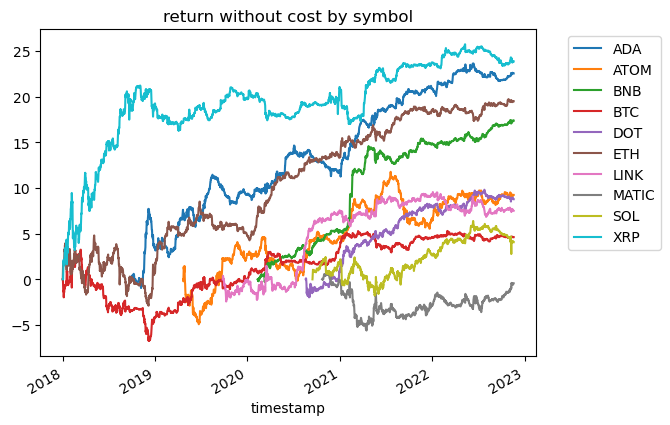

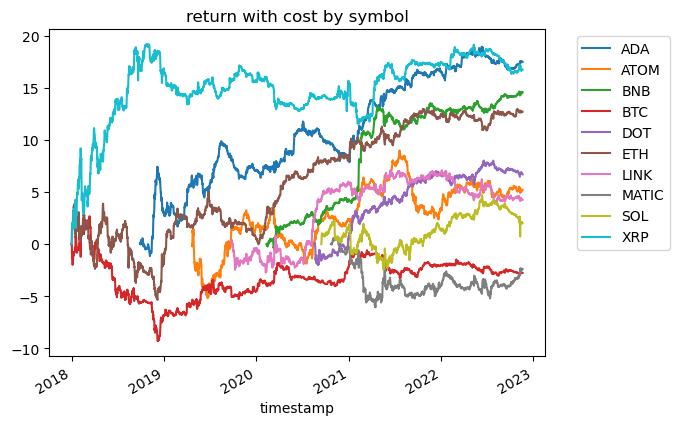

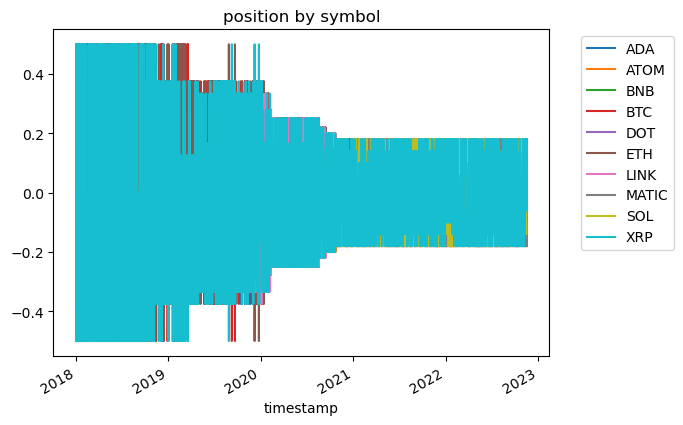

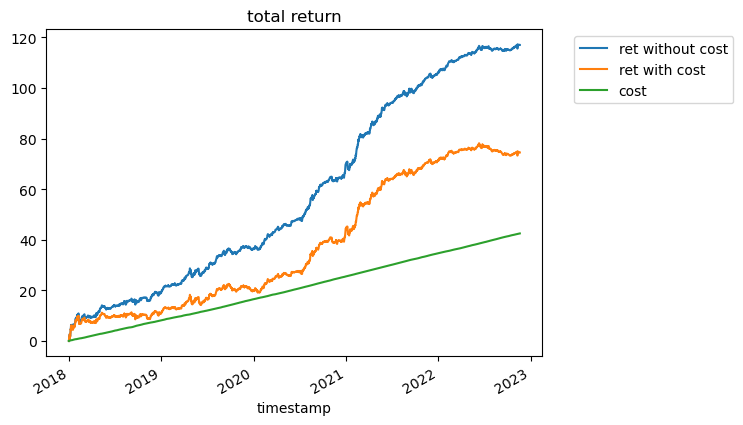

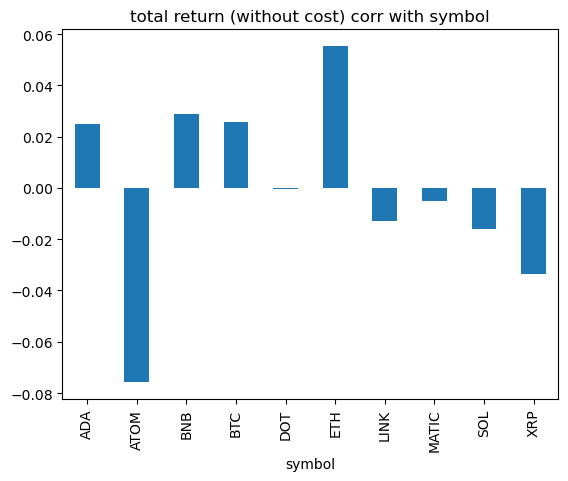

return without cost statistics
mean 0.002903024804862369
std 0.015783105726443657
sharpe 0.1839324183198319
double sharpe 1.240338642876488
max drawdown 3.385047067575943
min -0.10104567027570095
min sharpe 0.02872982876892724
return with cost statistics
mean 0.0019633681625873824
std 0.01576990525388069
sharpe 0.12450094854591677
double sharpe 0.7280053304724636
max drawdown 4.963250360710298
min -0.10200567027570095
min sharpe 0.019247637482120262


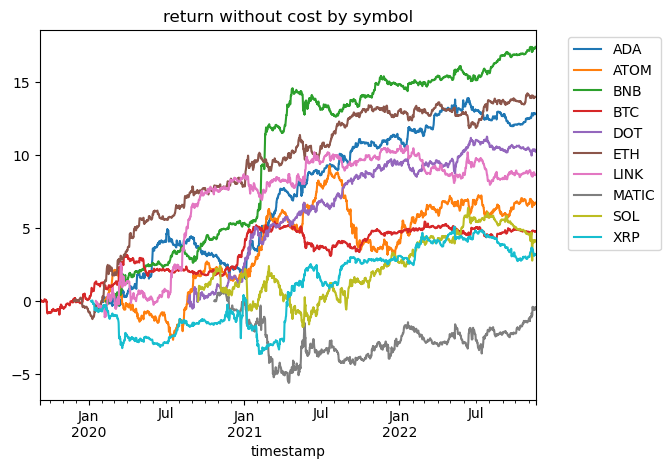

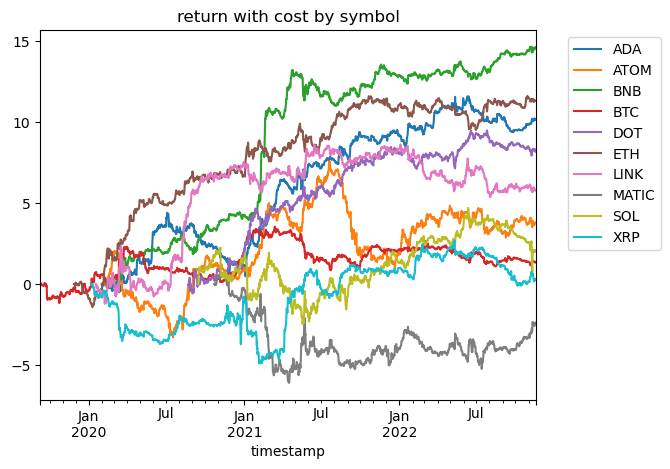

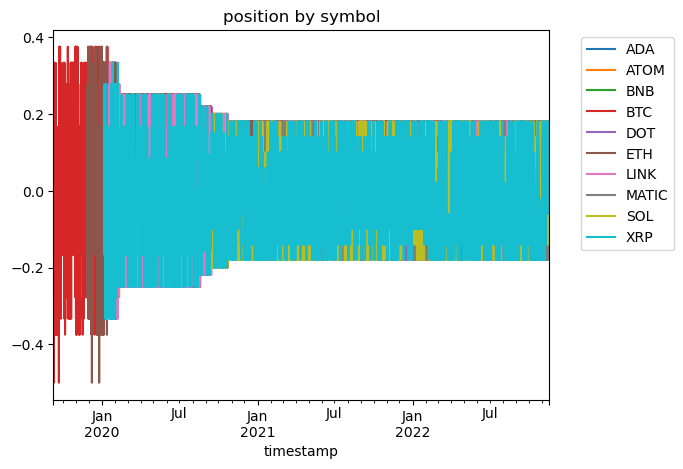

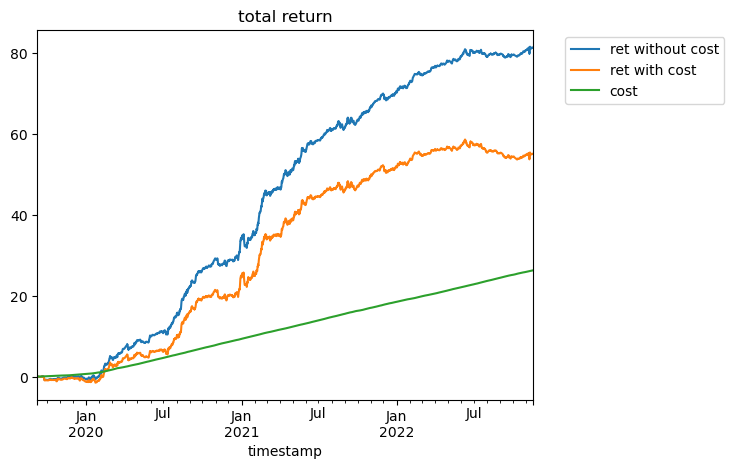

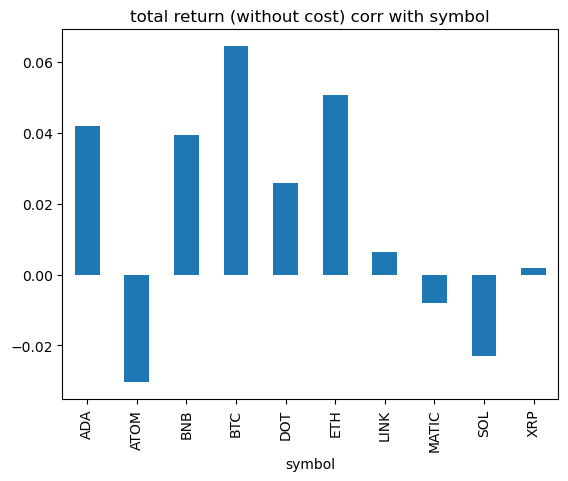

/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_45501/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_45501/3449756625.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

fit df.shape (303537, 528)


In [10]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-19 00:00:00Z')]
df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]
df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-25) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank()

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
visualize_result(df_cv.loc[~df_cv['extended']].dropna())
# visualize_result(df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2019-08-01 00:00:00Z')].dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220910_rank.xz', 'wb') as f:
    f.write(data)


/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_45501/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)


timestamp                  symbol
2022-07-22 18:00:00+00:00  ADA      -0.06
                           ATOM      0.18
                           BNB       0.10
                           BTC      -0.14
                           DOT       0.14
                                     ... 
2022-11-19 18:00:00+00:00  ETH       0.14
                           LINK     -0.02
                           MATIC    -0.18
                           SOL      -0.10
                           XRP       0.18
Name: position, Length: 28810, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_45501/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_45501/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

position1  position2  position3
timestamp                 symbol                                 
2022-07-22 19:00:00+00:00 ADA          0.06       0.06      -0.06
                          ATOM         0.14       0.14       0.18
                          BNB          0.10       0.10       0.02
                          BTC         -0.18      -0.18      -0.18
                          DOT          0.02       0.02      -0.10
...                                     ...        ...        ...
2022-11-19 17:00:00+00:00 ETH          0.14       0.14       0.14
                          LINK        -0.14      -0.14      -0.14
                          MATIC       -0.18      -0.18      -0.18
                          SOL          0.06       0.06       0.06
                          XRP          0.18       0.18       0.18

[28790 rows x 3 columns]

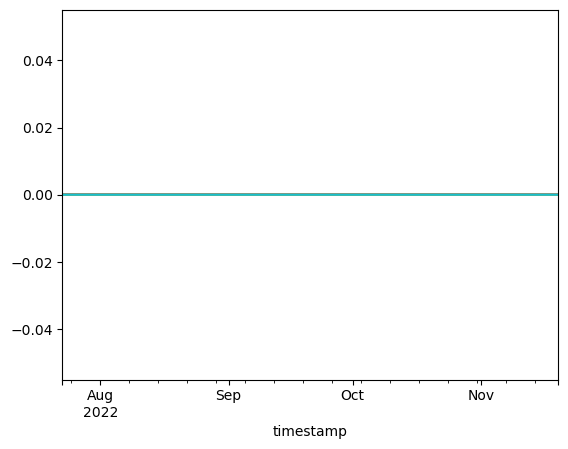

ADA (2879, 4)
ATOM (2879, 4)
BNB (2879, 4)
BTC (2879, 4)
DOT (2879, 4)
ETH (2879, 4)
LINK (2879, 4)
MATIC (2879, 4)
SOL (2879, 4)
XRP (2879, 4)


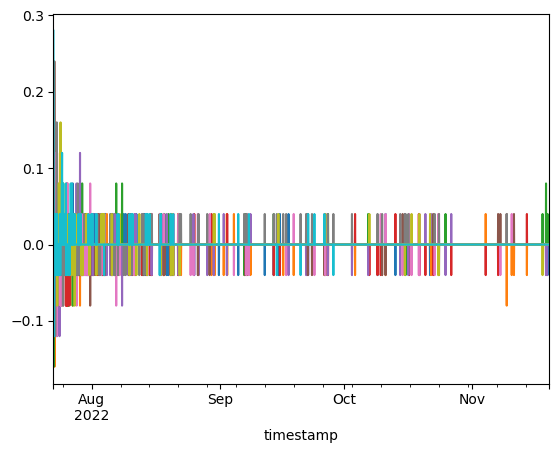

In [11]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220910_rank.xz')
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()